In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10)

In [3]:
# get latest dataset & load
df = pd.read_csv('https://aqicn.org/data-platform/covid19/report/15328-e2c2db48/2020', header=4, delimiter=',', sep=',')
df.head()

KeyboardInterrupt: 

In [5]:
# load dataset & inspect
path="/home/user/Documents/Gitlab/AMI/group19/final datasets/raw_data/"
df = pd.read_csv(path+'waqi-covid19-airqualitydata-2020.csv', header=4, delimiter=',', sep=',')
df.head()

Date Country   City Specie  count  min  max  median  variance
0  2020-01-29      FR  Tours     co     63  0.1  0.1     0.1       0.0
1  2020-04-27      FR  Tours     co     48  0.1  0.1     0.1       0.0
2  2020-05-28      FR  Tours     co     36  0.1  0.1     0.1       0.0
3  2020-04-03      FR  Tours     co     51  0.1  0.1     0.1       0.0
4  2020-04-08      FR  Tours     co     54  0.1  0.1     0.1       0.0

In [ ]:
# test osm api
from  geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my-application")

city='Neufahrn'
country='GR'

loc = geolocator.geocode(city+','+ country)
print(loc)
lat = loc.latitude
lon = loc.longitude
print(lat, lon)

In [5]:
def get_key():
    # load API KEY
    from dotenv import load_dotenv
    load_dotenv(override=True)
    import os
    from pwEncryption import decrypt

    api_key = os.getenv('PW')
    key = decrypt(api_key, useOwnSalt=False)
    return key

In [6]:
# test gmaps api
import requests
key = get_key()
city='Neufahrn'
country='GR'
response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+city+','+country+'&key='+key)
resp_json_payload = response.json()
print(resp_json_payload)

Decrypting your password.

{'results': [{'address_components': [{'long_name': 'Neufahrn bei Freising', 'short_name': 'Neufahrn bei Freising', 'types': ['locality', 'political']}, {'long_name': 'Freising', 'short_name': 'FS', 'types': ['administrative_area_level_3', 'political']}, {'long_name': 'Upper Bavaria', 'short_name': 'Upper Bavaria', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'Bavaria', 'short_name': 'BY', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'Germany', 'short_name': 'DE', 'types': ['country', 'political']}], 'formatted_address': 'Neufahrn bei Freising, Germany', 'geometry': {'bounds': {'northeast': {'lat': 48.3762445, 'lng': 11.705341}, 'southwest': {'lat': 48.2902493, 'lng': 11.5943159}}, 'location': {'lat': 48.3149823, 'lng': 11.6617978}, 'location_type': 'APPROXIMATE', 'viewport': {'northeast': {'lat': 48.3762445, 'lng': 11.705341}, 'southwest': {'lat': 48.2902493, 'lng': 11.5943159}}}, 'partial_match': True, 'place

In [147]:
# GMaps API -> 2$ per 1000 request, but 200$ free every month 
# add lat & lon to dataframe
import requests
from  geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my-application")
key=get_key()

lat = np.empty(len(df))
lon = np.empty(len(df))
prev_city = 'default'

for k in range(0, len(df)):
    city = df['City'][k]
    country = df['Country'][k]
    if city != prev_city:
        response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+city+','+country+'&key='+key)
        resp_json_payload = response.json()
        
    if resp_json_payload ['status'] != 'ZERO_RESULTS':
        lat[k] = resp_json_payload['results'][0]['geometry']['location']['lat']
        lon[k] = resp_json_payload['results'][0]['geometry']['location']['lng']
    elif city != prev_city:
        loc = geolocator.geocode(city+','+ country)
        if loc is None:
            lat[k] = np.nan
            lon[k] = np.nan
        else:
            lat[k] = loc.latitude
            lon[k] = loc.longitude
    prev_city = city

df['lat'] = lat
df['lon'] = lon

In [ ]:
# information about measurement points
response = requests.get('https://aqicn.org/data-platform/covid19/airquality-covid19-cities.json')
resp_json_payload = response.json()
print(resp_json_payload)

In [148]:
# convert date to datetime object & add year, year_week, year_day to dataframe
import datetime

df['Date'] = pd.to_datetime(df['Date'])

year_week = np.empty(len(df))
year = np.empty(len(df))
month = np.empty(len(df))
year_day = np.empty(len(df))
week_day = np.empty(len(df))

for k in range(len(df)):
    year[k] = df['Date'][k].isocalendar()[0]
    year_week[k] = df['Date'][k].isocalendar()[1]
    year_day[k] = df['Date'][k].timetuple().tm_yday
    month[k] = df['Date'][k].timetuple().tm_mon
    week_day[k] = df['Date'][k].timetuple().tm_wday
    
year_day = year_day.astype(int)
year_week = year_week.astype(int)
year = year.astype(int)
month = month.astype(int)
week_day = week_day.astype(int)

df['year'] = year
df['month'] = month
df['year_week'] = year_week
df['year_day'] = year_day
df['week_day'] = week_day

In [ ]:
# check unique values for duplicates
species = df['Specie'].unique()
print(species)
countries = df['Country'].unique()
print(countries)
cities = df['City'].unique()
print(cities)
lats = df['lat'].unique()
print(lats)
lons = df['lon'].unique()
print(lons)

In [149]:
# change duplicate specie values
df.replace(to_replace='wind gust', value='wind-gust', inplace=True)
df.replace(to_replace='wind speed', value='wind-speed', inplace=True)
df.replace(to_replace='wind-gust', value='wind_gust', inplace=True)
df.replace(to_replace='wind-speed', value='wind_speed', inplace=True)

In [150]:
# remove whitespaces and other fill characters
df['City'] = df['City'].str.replace('-', '_')
df['City'] = df['City'].str.replace('/', '')
df['City'] = df['City'].str.replace(' ', '_')
df['City'] = df['City'].str.replace('__', '_')
df['City'] = df['City'].str.replace('’', '_')
df['City'] = df['City'].str.replace('.', '')
df['City'] = df['City'].str.replace("'", '_')

In [151]:
# extract species to own dataframes
species = df['Specie'].unique()
for s in species:
    bl_specie = (df['Specie'] == s)
    x = df[bl_specie]
    exec("%s=x"  % (s))
    exec("%s.reset_index(inplace=True, drop=True)" % (s))

In [ ]:
# check if all measurements are available in each city and how are they distributed
max_cities = len(df['City'].unique())
print(max_cities)
all_cities = np.arange(0, max_cities)
for s in species:
    exec("counts = %s['City'].value_counts()"  % (s))
    cities = np.arange(0, len(counts))
    print(cities.shape)
    plt.bar(cities, counts)

plt.legend(df['Specie'].unique())
plt.ylabel('# of datapoints')
plt.xticks(all_cities, df['City'].unique())
plt.show()

95
(55,)
CN    8699
US    6514
JP    4669
IN    3643
ES    3529
      ... 
AE     143
IS     105
GE     104
GR      73
RE      71
Name: Country, Length: 55, dtype: int64
(68,)
CN    8698
JP    5257
FR    4520
US    4149
ES    3789
      ... 
IS     155
PE     146
BO     139
IE     126
GE     104
Name: Country, Length: 68, dtype: int64
(60,)
US    8829
CN    7606
JP    5252
FR    4322
ES    3773
      ... 
PE     146
BO     140
GE     104
MM      83
IR      16
Name: Country, Length: 60, dtype: int64
(89,)
US    9248
CN    8699
JP    5259
FR    3971
IN    3818
      ... 
CI      97
GN      96
IS      87
GH      78
PR      27
Name: Country, Length: 89, dtype: int64
(62,)
CN    8699
US    6216
JP    5258
FR    4521
ES    3797
      ... 
AR     156
PE     146
BO     139
IE     130
GE     104
Name: Country, Length: 62, dtype: int64
(89,)
US    8585
JP    3375
ES    3268
GB    2906
FR    2847
      ... 
TJ       4
LK       2
LA       2
GT       1
KW       1
Name: Country, Length: 89, dtype: i

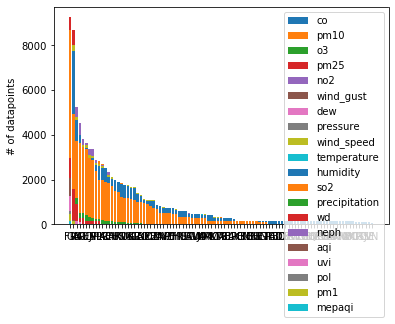

In [142]:
# check if all measurements are available in each country and how are they distributed
max_countries = len(df['Country'].unique())
print(max_countries)
all_countries = np.arange(0, max_countries)
for s in species:
    exec("counts = %s['Country'].value_counts()"  % (s))
    countries = np.arange(0, len(counts))
    print(countries.shape)
    print(counts)
    plt.bar(countries, counts)

plt.legend(df['Specie'].unique())
#plt.rcParams.update({'font.size': 10})
plt.ylabel('# of datapoints')
plt.xticks(all_countries, df['Country'].unique())
plt.show()

In [152]:
# delete rows of species with too low measurements (unique cities > 250, unique countries > 50)
species = df['Specie'].unique()
print(species)
#df.query('Specie' isin)
df = df[df['Specie'].isin(species[0:12])]
df = df.reset_index(drop=True)
species = df['Specie'].unique()
print(species)
print(len(df))

['co' 'pm10' 'o3' 'pm25' 'no2' 'wind_gust' 'dew' 'pressure' 'wind_speed'
 'temperature' 'humidity' 'so2' 'precipitation' 'wd' 'neph' 'aqi' 'uvi'
 'pol' 'pm1' 'mepaqi']
['co' 'pm10' 'o3' 'pm25' 'no2' 'wind_gust' 'dew' 'pressure' 'wind_speed'
 'temperature' 'humidity' 'so2']
946563


In [153]:
# keep only entries with all measurements available
species = df['Specie'].unique()
mask_countries = co['Country'].unique()
mask_cities = co['City'].unique()

for s in species:
    exec("mask_countries1 = %s['Country'].unique()" % (s))
    exec("mask_cities1 = %s['City'].unique()" % (s))
    mask_countries = np.intersect1d(mask_countries, mask_countries1)
    mask_cities = np.intersect1d(mask_cities, mask_cities1)
    
#print(mask_countries)
print(len(mask_countries))
#print(mask_cities)
print(len(mask_cities))

df = df[df['Country'].isin(mask_countries)]
df = df[df['City'].isin(mask_cities)]
df = df.reset_index(drop=True)
print(len(df['City'].unique()))
print(len(df['Country'].unique()))
print(len(df))

42
254
254
42
454012


In [ ]:
# delete rows where count is lower than 10 -> needed? two measures per day enough?
print(len(df))
df = df.mask(df['count'].le(10))
df.dropna(inplace=True)
df = df.reset_index(drop=True)
print(len(df))

In [159]:
# drop unneeded columns
c_list = ['count', 'min', 'max', 'variance']
df.drop(columns=c_list, inplace=True)
df.rename(columns={'median': 'value'}, inplace=True)
df.head()

Date Country       City Specie  value        lat      lon  year  \
0 2020-01-04      FR  Marseille   pm10   10.0  43.296482  5.36978  2020   
1 2020-01-28      FR  Marseille   pm10   22.0  43.296482  5.36978  2020   
2 2020-02-22      FR  Marseille   pm10   23.0  43.296482  5.36978  2020   
3 2020-03-19      FR  Marseille   pm10   25.0  43.296482  5.36978  2020   
4 2020-05-18      FR  Marseille   pm10   19.0  43.296482  5.36978  2020   

   month  year_week  year_day  week_day  
0      1          1         4         5  
1      1          5        28         1  
2      2          8        53         5  
3      3         12        79         3  
4      5         21       139         0

In [160]:
# extract species to own dataframes
species = df['Specie'].unique()
for s in species:
    bl_specie = (df['Specie'] == s)
    x = df[bl_specie]
    exec("%s=x"  % (s))
    exec("%s.reset_index(inplace=True, drop=True)" % (s))

In [161]:
# extract city & specie to single dataframes
cities = df['City'].unique()
species = df['Specie'].unique()
for s in species:
    for c in cities:
        exec("bl_city = (%s['City'] == c)" % (s))
        exec("x = %s[bl_city]" % (s))
        exec("%s_%s=x"  % (s,c))
        exec("%s_%s.reset_index(inplace=True, drop=True)" % (s,c))

In [356]:
# interpolate missing values (for day of the year) -> TODO
today = datetime.now()
today_year_day = today.timetuple().tm_yday

year_day = np.arange(1, today_year_day)
cities = df['City'].unique()
species = df['Specie'].unique()
for s in species:
    for c in cities:
        exec("np.intersect1d(%s_%s['year_day'].unique(),year_day)"  % (s,c)) 

1

In [162]:
df.head()

Date Country       City Specie  value        lat      lon  year  \
0 2020-01-04      FR  Marseille   pm10   10.0  43.296482  5.36978  2020   
1 2020-01-28      FR  Marseille   pm10   22.0  43.296482  5.36978  2020   
2 2020-02-22      FR  Marseille   pm10   23.0  43.296482  5.36978  2020   
3 2020-03-19      FR  Marseille   pm10   25.0  43.296482  5.36978  2020   
4 2020-05-18      FR  Marseille   pm10   19.0  43.296482  5.36978  2020   

   month  year_week  year_day  week_day  
0      1          1         4         5  
1      1          5        28         1  
2      2          8        53         5  
3      3         12        79         3  
4      5         21       139         0

In [170]:
co['value'][1:10]

1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: value, dtype: float64

In [189]:
x = co['value'][1] - mean_co
y = x / (var_co * var_co)
print(y)
print(co['value'][1])

-0.00240125482871407
0.1


In [190]:
np.var(y)

0.0

In [186]:
np.var(val_norm)

2.936847497370041e-12

In [184]:
# normalize data (use specie dataframes, normalize and put together to get df)
for s in species:
    print(s)
    exec("%s['value'][1]" % (s))
    
    exec("mean = np.mean(%s['value'])" % (s))
    exec("var = np.var(%s['value'])" % (s))
    exec("val_norm = (%s['value'] - mean) / (var * var)" % (s))
    print(val_norm[1])

    #exec("s[median] = val_norm", %(s))

pm10
-2.0644882903351355e-05
wind_speed
-0.0003197787109896998
dew
-0.0009371820786462477
temperature
-0.0010318565305234395
humidity
-9.640815381058772e-05
co
-0.00240125482871407
o3
-0.0012463268546589427
so2
-0.0007475665360875051
wind_gust
-0.004896450550168403
pm25
-8.974743964480677e-06
no2
-0.0010659040679580547
pressure
3.8501469865018956e-07


In [432]:
# save dataframe as enhanced dataset
df.to_csv('/home/user/Documents/Datasets/AMI/Air pollution/waqi-covid19-airqualitydata-2020_enhanced.csv', sep=',', index=False)

In [48]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
pd.set_option('display.max_rows', 10)

In [35]:
# load new enhanced dataset & inspect
df = pd.read_csv('/home/user/Documents/Datasets/AMI/Air pollution/waqi-covid19-airqualitydata-2020_enhanced.csv', delimiter=',', sep=',')
df.head()

Date Country       City Specie  value        lat         lon  year  \
0  2020-06-21      HK  Hong_Kong     co    3.6  22.319304  114.169361  2020   
1  2020-02-02      HK  Hong_Kong     co    6.8  22.319304  114.169361  2020   
2  2020-02-13      HK  Hong_Kong     co    6.7  22.319304  114.169361  2020   
3  2020-02-27      HK  Hong_Kong     co    5.5  22.319304  114.169361  2020   
4  2020-03-15      HK  Hong_Kong     co    7.0  22.319304  114.169361  2020   

   month  year_week  year_day  week_day  
0      6         25       173         6  
1      2          5        33         6  
2      2          7        44         3  
3      2          9        58         3  
4      3         11        75         6

In [36]:
# convert date to datetime object
df['Date'] = pd.to_datetime(df['Date'])
df.head()

Date Country       City Specie  value        lat         lon  year  \
0 2020-06-21      HK  Hong_Kong     co    3.6  22.319304  114.169361  2020   
1 2020-02-02      HK  Hong_Kong     co    6.8  22.319304  114.169361  2020   
2 2020-02-13      HK  Hong_Kong     co    6.7  22.319304  114.169361  2020   
3 2020-02-27      HK  Hong_Kong     co    5.5  22.319304  114.169361  2020   
4 2020-03-15      HK  Hong_Kong     co    7.0  22.319304  114.169361  2020   

   month  year_week  year_day  week_day  
0      6         25       173         6  
1      2          5        33         6  
2      2          7        44         3  
3      2          9        58         3  
4      3         11        75         6

In [ ]:
# extract species to own dataframes
species = df['Specie'].unique()
for s in species:
    bl_specie = (df['Specie'] == s)
    x = df[bl_specie]
    exec("%s=x"  % (s))
    exec("%s.reset_index(inplace=True, drop=True)" % (s))

In [71]:
# extract specie_city to single dataframes
cities = df['City'].unique()
species = df['Specie'].unique()
for s in species:
    for c in cities:
        exec("bl_city = (%s['City'] == c)" % (s))
        exec("x = %s[bl_city]" % (s))
        exec("%s_%s=x"  % (s,c))
        exec("%s_%s.reset_index(inplace=True, drop=True)" % (s,c))

SyntaxError: invalid syntax (<string>, line 1)

ValueError: num must be 1 <= num <= 12, not 13

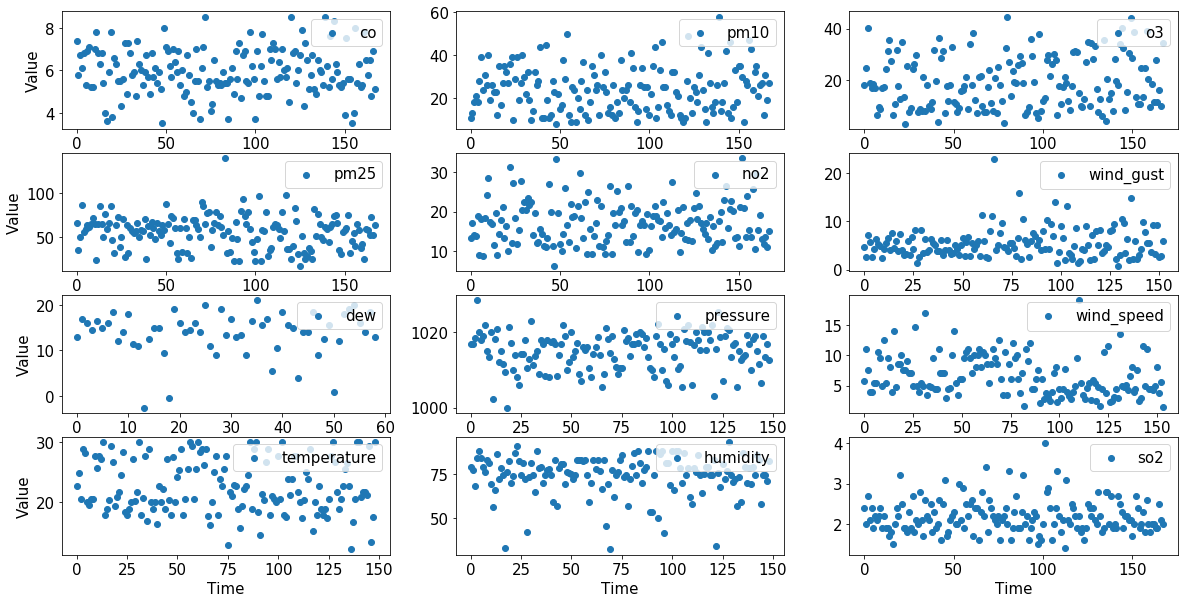

In [134]:
cities = df['City'].unique()
species = df['Specie'].unique()
c = 'Hong_Kong'
i=1
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 15})
plt.rcParams["legend.loc"] = 'upper right'

for s in species:
    #for c in cities:
    ax = plt.subplot(4, 3, i)
    exec("value = %s_%s['median']"  % (s,c))
    t=np.arange(0, len(value))
    plt.scatter(t, value)
    plt.legend([s])
    if i == 1 or i == 4 or i == 7 or i == 10:
        plt.ylabel('Value')
    if i > 9:
        plt.xlabel('Time')
    i=i+1
    
plt.subplot(4, 3, 4)
plt.ylabel('Value')
plt.subplot(4, 3, 11)
plt.xlabel('Time')

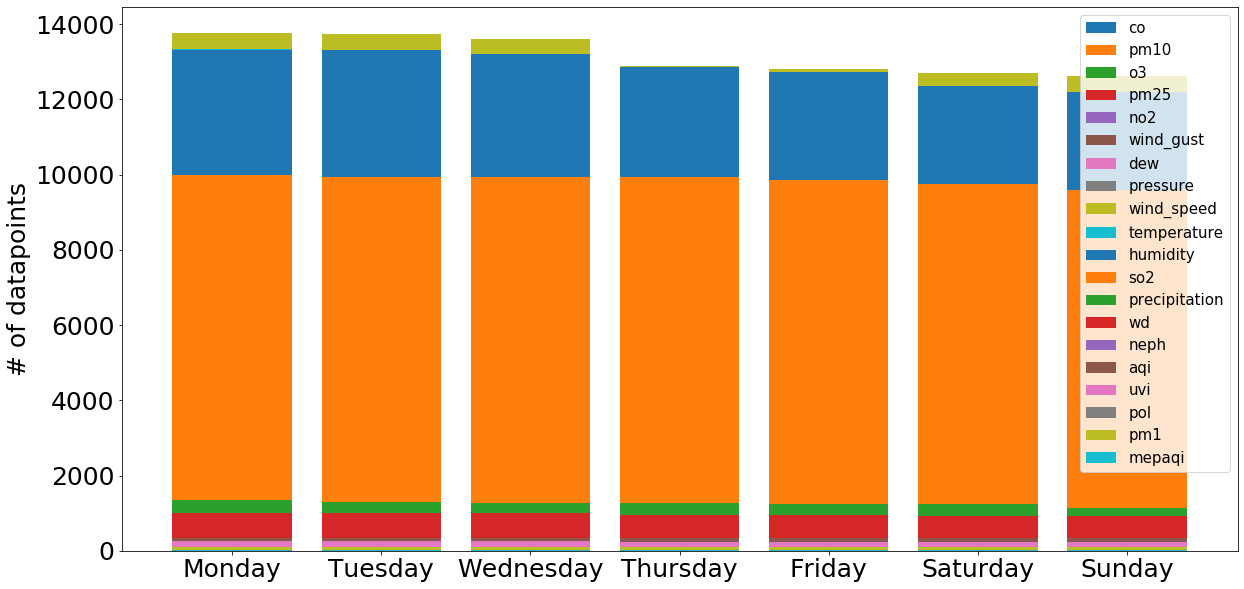

In [63]:
# count number of sample for each week day for each species

species = df['Specie'].unique()
weekday = np.arange(0, 7)
plt.figure(figsize=(20,10))

for s in species:
    exec("counts = %s['week_day'].value_counts()"  % (s))
    plt.bar(weekday, counts)

plt.rcParams.update({'font.size': 15})
plt.legend(df['Specie'].unique())
plt.rcParams.update({'font.size': 20})
plt.xticks(weekday, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.ylabel('# of datapoints')
plt.show()

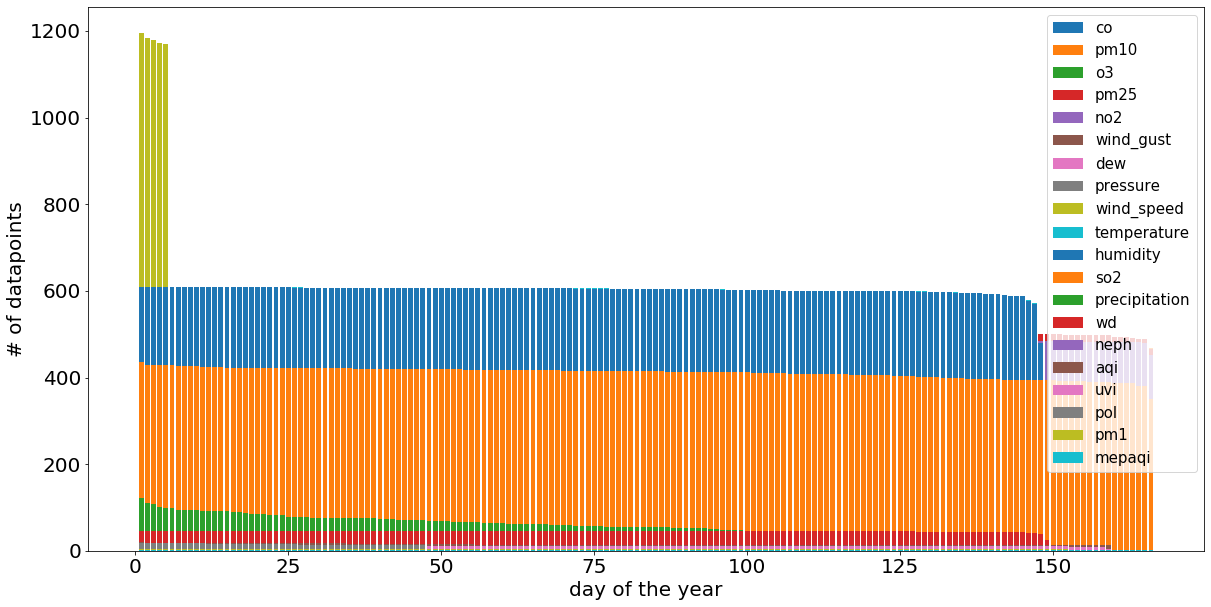

In [64]:
# count number of samples for each day of the year
species = df['Specie'].unique()
today = datetime.datetime.now()
today_year_day = today.timetuple().tm_yday
plt.figure(figsize=(20,10))

for s in species:
    exec("bl = %s['year_day'].le(today_year_day)" % (s))
    exec("counts = %s['year_day'][bl].value_counts()"  % (s))
    year_days = np.arange(1, len(counts)+1)
    plt.bar(year_days, counts)

plt.rcParams.update({'font.size': 15})
plt.legend(df['Specie'].unique())
plt.rcParams.update({'font.size': 30})
plt.ylabel('# of datapoints')
plt.xlabel('day of the year')
plt.show()

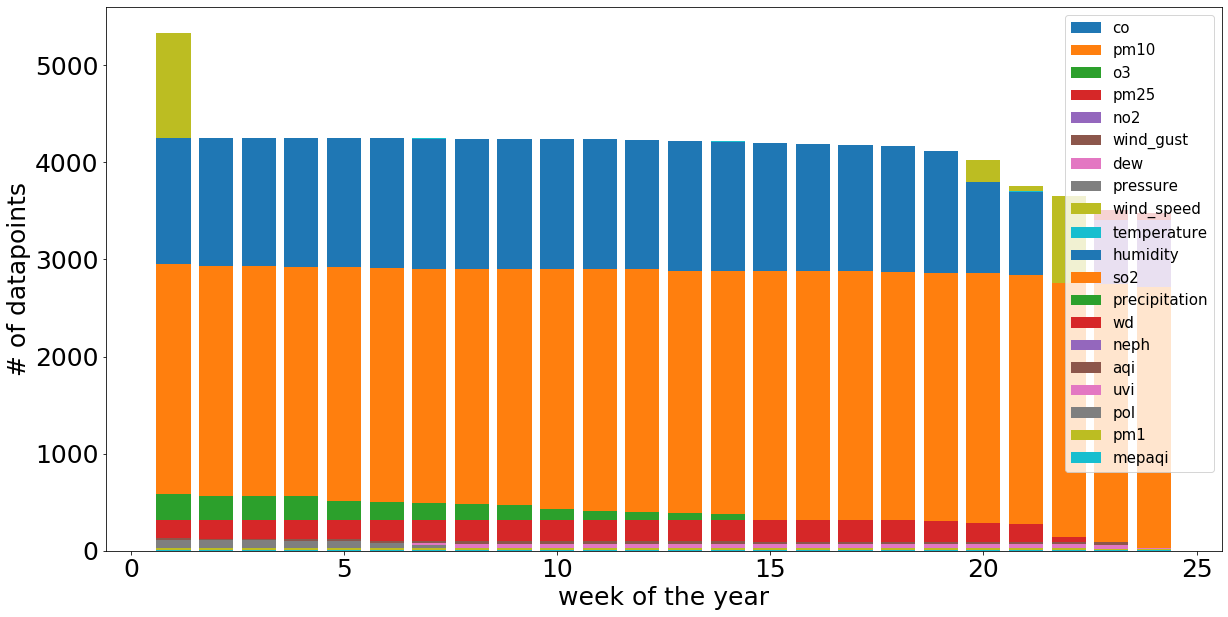

In [66]:
# count number of samples for each week for each species
species = df['Specie'].unique()
today = datetime.datetime.now()
today_year_week = today.isocalendar()[1]
plt.figure(figsize=(20,10))

for s in species:
    exec("bl = %s['year_week'].le(today_year_week)" % (s))
    exec("counts = %s['year_week'][bl].value_counts()"  % (s))
    year_weeks = np.arange(1, len(counts)+1)
    plt.bar(year_weeks, counts)

plt.rcParams.update({'font.size': 15})
plt.legend(df['Specie'].unique())
plt.rcParams.update({'font.size': 20})
plt.ylabel('# of datapoints')
plt.xlabel('week of the year')
plt.show()

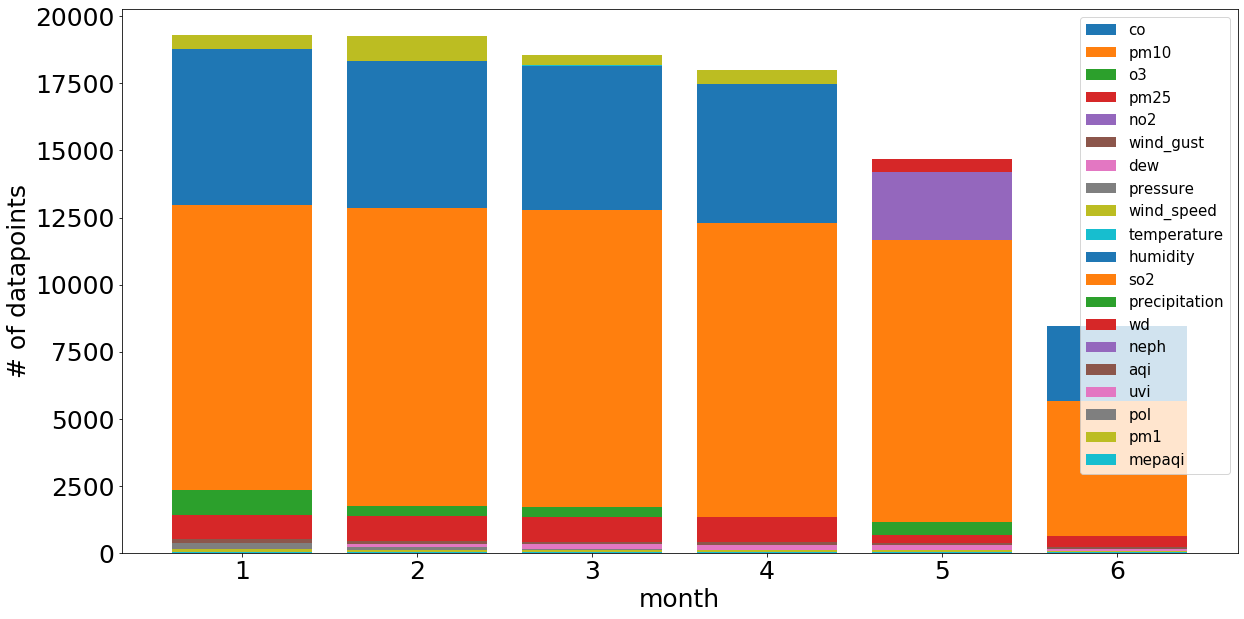

In [69]:
# count number of samples for each month for each species
species = df['Specie'].unique()
today = datetime.datetime.now()
today_month = today.timetuple().tm_mon
plt.figure(figsize=(20,10))

for s in species:
    exec("bl = %s['month'].le(today_month)" % (s))
    exec("counts = %s['month'][bl].value_counts()"  % (s))
    months = np.arange(1, len(counts)+1)
    plt.bar(months, counts)

plt.rcParams.update({'font.size': 15})
plt.legend(df['Specie'].unique())
plt.rcParams.update({'font.size': 20})
plt.ylabel('# of datapoints')
plt.xlabel('month')
plt.show()

In [6]:
# check if samples per day are equal for the same city -> Nope
df.head()

Date Country       City Specie  value        lat         lon  year  \
0 2020-06-21      HK  Hong_Kong     co    3.6  22.319304  114.169361  2020   
1 2020-02-02      HK  Hong_Kong     co    6.8  22.319304  114.169361  2020   
2 2020-02-13      HK  Hong_Kong     co    6.7  22.319304  114.169361  2020   
3 2020-02-27      HK  Hong_Kong     co    5.5  22.319304  114.169361  2020   
4 2020-03-15      HK  Hong_Kong     co    7.0  22.319304  114.169361  2020   

   month  year_week  year_day  week_day  
0      6         25       173         6  
1      2          5        33         6  
2      2          7        44         3  
3      2          9        58         3  
4      3         11        75         6

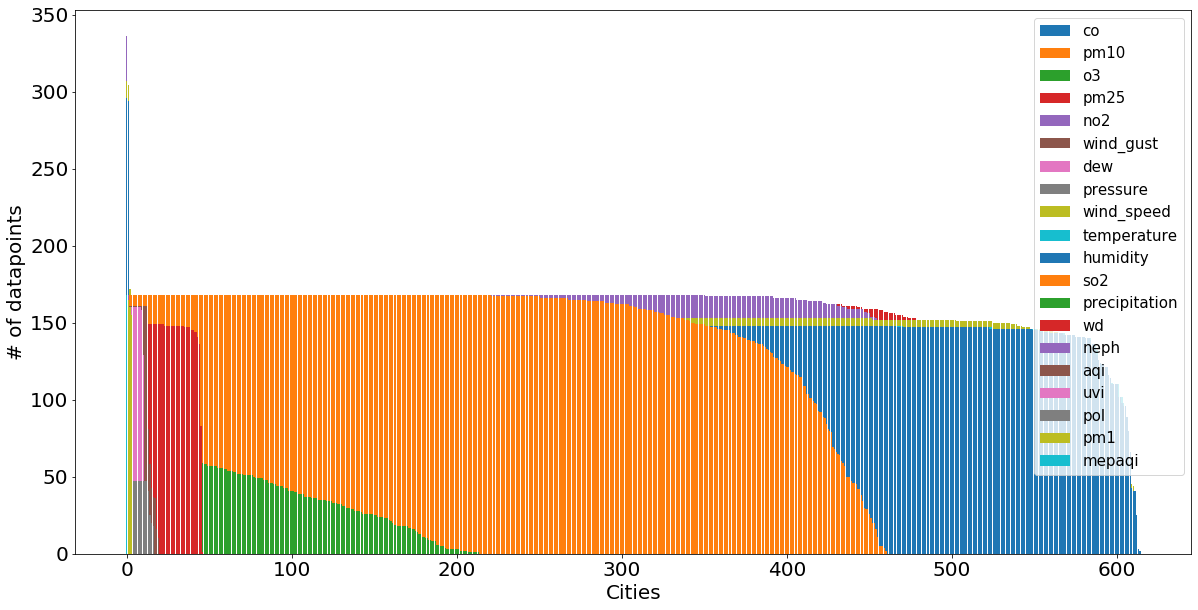

In [82]:
# check if all measurements are available in each city and how are they distributed
max_cities = len(df['City'].unique())
#print(max_cities)
all_cities = np.arange(0, max_cities)
plt.figure(figsize=(20,10))

for s in species:
    exec("counts = %s['City'].value_counts()"  % (s))
    cities = np.arange(0, len(counts))
    #print(cities.shape)
    plt.bar(cities, counts)

plt.rcParams.update({'font.size': 15})
plt.legend(df['Specie'].unique())
plt.rcParams.update({'font.size': 30})
plt.ylabel('# of datapoints')
#plt.xticks(all_cities, df['City'].unique())
plt.xlabel('Cities')
plt.show()

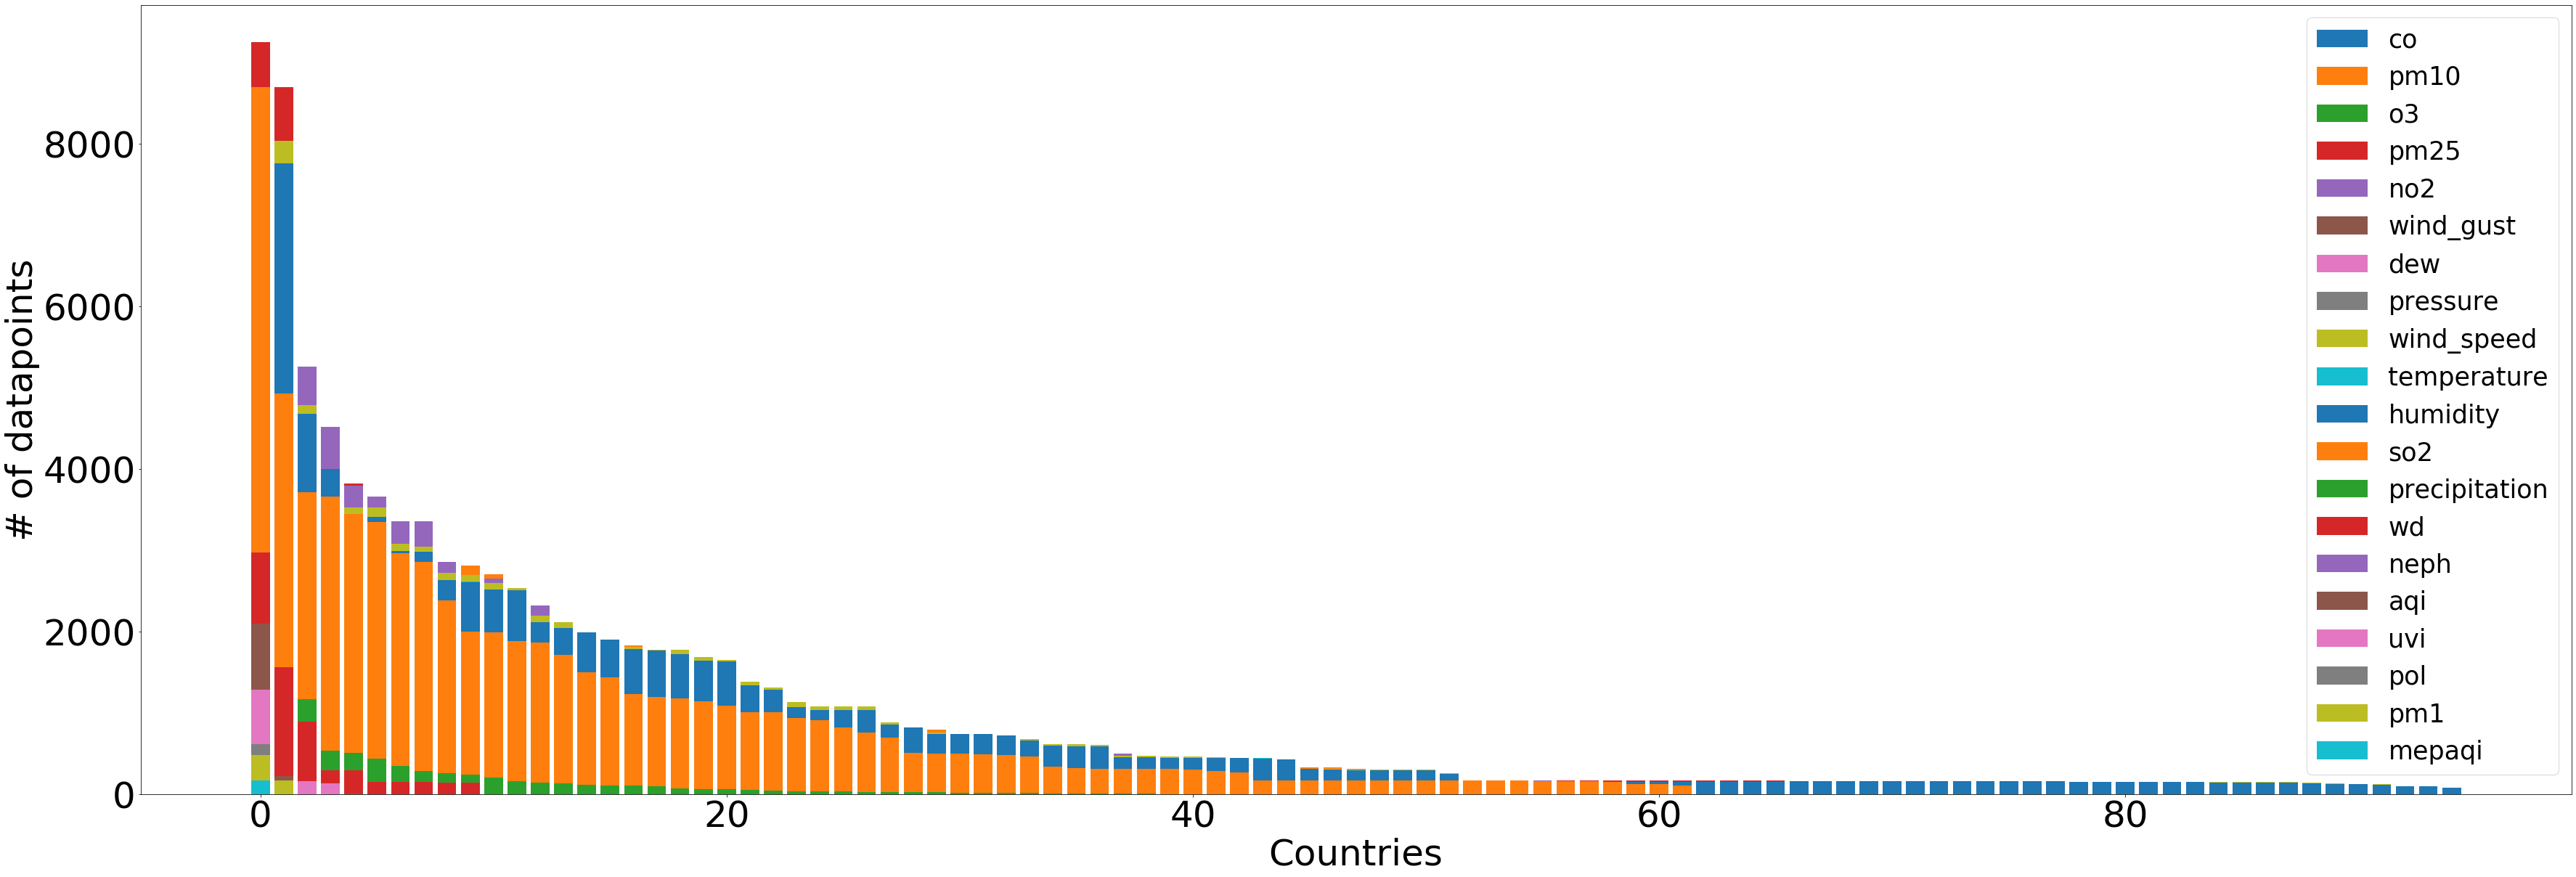

In [105]:
# check if all measurements are available in each country and how are they distributed

#plt.rcParams.update({'font.size': 22})

max_countries = len(df['Country'].unique())
#print(max_countries)
all_countries = np.arange(0, max_countries)
plt.figure(figsize=(60,20))

for s in species:
    exec("counts = %s['Country'].value_counts()"  % (s))
    countries = np.arange(0, len(counts))
    #print(countries.shape)
    #print(counts)
    plt.bar(countries, counts)

plt.legend(df['Specie'].unique(), prop={"size":35})
#plt.xticks(all_countries, df['Country'].unique())
plt.rcParams.update({'font.size': 50})
plt.ylabel('# of datapoints')
plt.xlabel('Countries')
plt.show()

In [95]:
df['Country'].unique()

array(['FR', 'GB', 'IN', 'AR', 'AU', 'CO', 'ES', 'JP', 'NL', 'PK', 'PR',
       'AE', 'CA', 'CH', 'HK', 'US', 'RU', 'TM', 'UG', 'GT', 'KZ', 'LA',
       'RO', 'BE', 'ID', 'PH', 'CZ', 'ZA', 'MY', 'NP', 'NZ', 'PT', 'CY',
       'HR', 'HU', 'IL', 'SA', 'SG', 'SV', 'TW', 'UA', 'JO', 'KR', 'MK',
       'MO', 'LT', 'MX', 'TR', 'AF', 'BA', 'BR', 'LK', 'PE', 'CI', 'CN',
       'KG', 'MN', 'BH', 'EE', 'GN', 'ET', 'GR', 'IE', 'IT', 'AT', 'BO',
       'DE', 'DZ', 'IR', 'KW', 'RE', 'TH', 'EC', 'GE', 'GH', 'IQ', 'UZ',
       'NO', 'PL', 'RS', 'SK', 'BD', 'DK', 'FI', 'ML', 'CW', 'MM', 'XK',
       'BG', 'CR', 'IS', 'TJ', 'CL', 'SE', 'VN'], dtype=object)

In [ ]:
# check if all species have enough measurements

plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(60,20))

species = df['Specie'].unique()

counts = df['Specie'].value_counts()
plt.bar(species, counts)

plt.ylabel('# of datapoints')
plt.xticks(rotation=45) 
plt.show()

In [ ]:
df.hist()

In [ ]:
df['count'].plot.hist()

In [ ]:
# check min value for count
n_species = np.arange(0, len(df['Specie'].unique()))
mins = np.empty(len(n_species))
k=0

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20,10))

for s in species:
    exec("mini = %s['count'].min()"  % (s))
    mins[k] = mini
    k=k+1
    
plt.scatter(n_species, mins)

plt.ylabel('min value for counts')
plt.xticks(n_species, df['Specie'].unique())
plt.xticks(rotation=45) 
plt.show()

In [ ]:
# check median value for count
n_species = np.arange(0, len(df['Specie'].unique()))
medians = np.empty(len(n_species))
k=0

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20,10))

for s in species:
    exec("medi = %s['count'].median()"  % (s))
    medians[k] = medi
    k=k+1
    
plt.scatter(n_species, medians)

plt.ylabel('median value for counts')
plt.xticks(n_species, df['Specie'].unique())
plt.xticks(rotation=45) 
plt.show()

In [ ]:
df['count'].plot.box()
df['min'].plot.box()
df['max'].plot.box()
df['value'].plot.box()

In [17]:
df['Specie'].unique()

array(['co', 'temperature', 'wind_gust', 'o3', 'so2', 'pm25', 'no2',
       'dew', 'wind_speed', 'uvi', 'pm10', 'humidity'], dtype=object)

ValueError: num must be 1 <= num <= 12, not 13

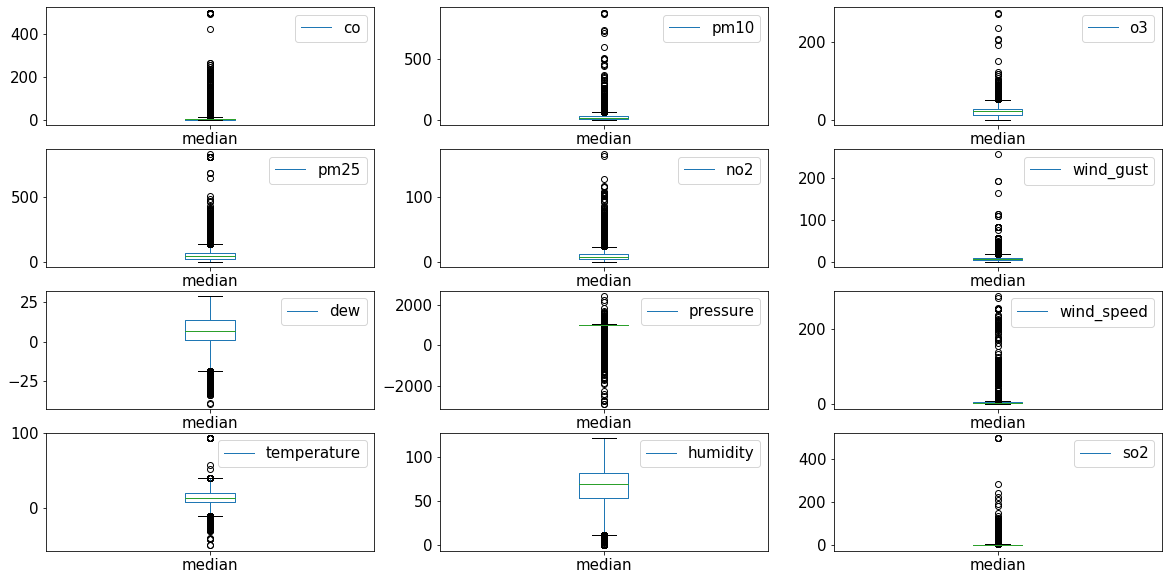

In [136]:
species = df['Specie'].unique()
plt.figure(figsize=(20,10))

i=1;

for s in species:
    ax = plt.subplot(4, 3, i)
    exec("value = %s['median']"  % (s))
    value.plot.box()
    plt.legend([s])
    i = i+1
    
#plt.legend(df['Specie'].unique())
#plt.xticks(weekday, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
#plt.ylabel('# of datapoints')
plt.show()

ValueError: num must be 1 <= num <= 12, not 13

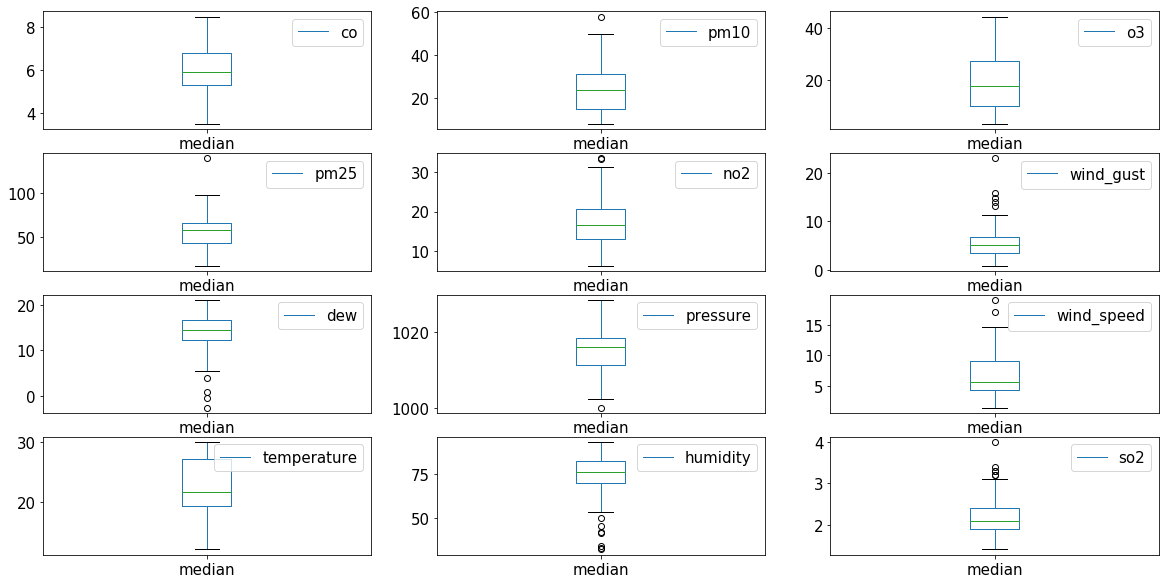

In [140]:
cities = df['City'].unique()
species = df['Specie'].unique()
c = 'Hong_Kong'
i=1
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 15})
plt.rcParams["legend.loc"] = 'upper right'

for s in species:
    #for c in cities:
    ax = plt.subplot(4, 3, i)
    exec("value = %s_%s['median']"  % (s,c))
    value.plot.box()
    plt.legend([s])
    i=i+1


In [ ]:
# correlation matrix (seaborn)
import seaborn as sn

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20,10))

corrMat = df.corr()

sn.heatmap(corrMat, annot=True)
plt.show()

In [ ]:
import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

reader = shpreader.Reader(shpfilename)
countries = reader.records()
country = next(countries)

print(country.attributes.keys())